In [3]:
from rdkit import Chem
from mordred import Calculator, descriptors
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [4]:
calc = Calculator(descriptors, ignore_3D=True)

def get_desc(smile):
    mol = Chem.MolFromSmiles(smile)
    return calc(mol)

#### Загрузка датасета

In [5]:
df = pd.read_csv('IGC50_connected.csv')
df

,smiles,label
0,O=[N+]([O-])c1ccc(Cl)cc1,3.43
1,Nc1ccc([N+](=O)[O-])cc1,4.12
2,CCOc1ccc([N+](=O)[O-])cc1,3.83
3,ClCc1ccccc1,3.06
4,N#Cc1ccccc1,2.48
...,...,...
1787,CCOC(=O)c1ccc([N+](=O)[O-])cc1,3.71
1788,CC(C)c1ccc(N)cc1,3.22
1789,O=C(O)c1ccc(O)cc1,1.98
1790,C=CCOC(=O)C=C,3.68


In [8]:
X = np.array(list(map(lambda x: get_desc(x), df['smiles'])), dtype=float)
y = np.array(df['label'])

X.shape, y.shape

((1792, 1613), (1792,))

#### Пример молекулы

O=Cc1ccc(O)cc1


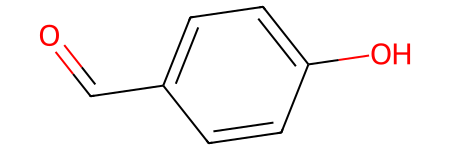

In [9]:
view = df.iloc[73]
view_mol = Chem.MolFromSmiles(view['smiles'])
print(view['smiles'])
view_mol

#### Разделение на обучающую и тренировочную выборки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [11]:
def print_metrics(y_test, y_pred):
    print(
        f'MAE: {mean_absolute_error(y_test, y_pred)}\n'
        f'MSE: {mean_squared_error(y_test, y_pred)}\n'
        f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}\n'
        f'R^2: {r2_score(y_test, y_pred)}\n'
        f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}'
    )

## sklearn

### Проверили кросс-валидацию

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
rmse = []

for train_index, test_index in kfold.split(X, y):
    xgbr = XGBRegressor().fit(X[train_index], y[train_index])
    y_pred_xgbr = xgbr.predict(X[test_index])
    rmse.append(np.sqrt(mean_squared_error(y[test_index], y_pred_xgbr)))
    print('RMSE:', rmse[-1], end='\n\n')

print(np.mean(rmse))

RMSE: 0.5263110009999005

RMSE: 0.49210974691710524

RMSE: 0.5190873640297528

RMSE: 0.5225641131920082

RMSE: 0.49416569955169715

0.5108475849380928


In [18]:
xgbr_kf = XGBRegressor(early_stopping_rounds=10, random_state=0, seed=0).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
y_pred_xgbr_kf = xgbr_kf.predict(X_test)
print_metrics(y_test, y_pred_xgbr_kf)

[0]	validation_0-rmse:2.10916	validation_1-rmse:2.16206
[1]	validation_0-rmse:1.52766	validation_1-rmse:1.59196
[2]	validation_0-rmse:1.11927	validation_1-rmse:1.20506
[3]	validation_0-rmse:0.82991	validation_1-rmse:0.95506
[4]	validation_0-rmse:0.62934	validation_1-rmse:0.79884
[5]	validation_0-rmse:0.48915	validation_1-rmse:0.69710
[6]	validation_0-rmse:0.39171	validation_1-rmse:0.63868
[7]	validation_0-rmse:0.32059	validation_1-rmse:0.60076
[8]	validation_0-rmse:0.27152	validation_1-rmse:0.57829
[9]	validation_0-rmse:0.23905	validation_1-rmse:0.56565
[10]	validation_0-rmse:0.21063	validation_1-rmse:0.55714
[11]	validation_0-rmse:0.19068	validation_1-rmse:0.55384
[12]	validation_0-rmse:0.17803	validation_1-rmse:0.54906
[13]	validation_0-rmse:0.16812	validation_1-rmse:0.54593
[14]	validation_0-rmse:0.15733	validation_1-rmse:0.54432
[15]	validation_0-rmse:0.14860	validation_1-rmse:0.54390
[16]	validation_0-rmse:0.14452	validation_1-rmse:0.54267
[17]	validation_0-rmse:0.13629	validation

In [19]:
results = xgbr_kf.evals_result()
results['validation_1']['rmse'][-1]

0.5346539529968766

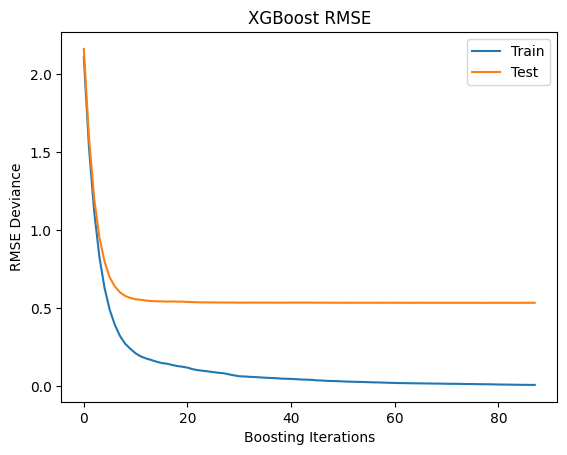

In [20]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right")

### XGB

In [21]:
xgbr = XGBRegressor().fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
print_metrics(y_test, y_pred_xgbr)

MAE: 0.38546849007058787
MSE: 0.2857373670669544
MAPE: 0.1349418047068904
R^2: 0.7494066445078233
RMSE: 0.5345440740172455


### CatBoost

In [22]:
cbr = CatBoostRegressor().fit(X_train, y_train, verbose=False)
y_pred_cbr = cbr.predict(X_test)
print_metrics(y_test, y_pred_cbr)

MAE: 0.3329175106762163
MSE: 0.21045082012284502
MAPE: 0.11744394989003643
R^2: 0.8154333900322296
RMSE: 0.4587491908688723


Можно бы было подобрать много гиперпараметров, но у нас нет столько мощностей

In [ ]:
params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01],
    'depth': [3, 5],
    'l2_leaf_reg': [3, 5],
    'random_seed': [42],
    'bagging_temperature': [0.6, 0.8, 1],
    'border_count': [32, 64, 128]
}

cb = CatBoostRegressor(task_type="GPU", devices="0:1") 

grid = GridSearchCV(estimator=cb, param_grid=params, n_jobs=4, verbose=3)

grid.fit(X_train, y_train)

## Сохранение

In [ ]:
def save(X: np.ndarray, estimator, filename: str) -> None:
    pd.DataFrame({'smiles': X, 'label': estimator.predict(X)}).to_csv(f'answers/{filename}.csv', index=False)

In [ ]:
save(X_test, cbr, 'igc50_40h_tetra_pred')